<a href="https://colab.research.google.com/github/tg-bomze/DFDNet/blob/master/DFDNet_Colab_Rus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">DFDNet Colab Rus</font></b>

<b><font color="black" size="+2">Базируется на:</font></b>

**GitHub репозиторий**: [DFDNet](https://github.com/csxmli2016/DFDNet)

Статья: [Blind Face Restoration via Deep Multi-scale Component Dictionaries](https://arxiv.org/pdf/2008.00418.pdf)

Опубликовал: **[csxmli2016](https://github.com/csxmli2016).**

<b><font color="black" size="+2">Колаб собрал:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).


```
Далее тыкай на кнопки (куда указывает красная стрелка) в каждом блоке поочередно. После нажатия дождись окончания выполнения.
```



In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Клонируем репозиторий и устанавливаем все необходимые компоненты</font></b>
!pip install dominate

from google.colab import drive
from IPython.display import clear_output
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")
%matplotlib inline

!rm -rf /content/sample_data
!git clone https://github.com/tg-bomze/DFDNet.git

!mkdir /content/DFDNet/checkpoints/
!mkdir /content/DFDNet/checkpoints/facefh_dictionary
!mkdir /content/DFDNet/weights/
!mkdir /content/DFDNet/DictionaryCenter512/

os.chdir('/content/DFDNet/FaceLandmarkDetection/')
!python setup.py install
os.chdir('/content/')
clear_output()
!nvidia-smi -L

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Сохраняем веса предобученной модели и монтируем гугл драйв</font></b>
#@markdown *Внимание! Если веса уже сохранены, то запустите этот блок и только смонтируйте Гугл Драйв.*

print("Перейдите по следующей ссылке:")
print("https://drive.google.com/drive/folders/1bayYIUMCSGmoFPyd4Uu2Uwn347RW-vl5")
print("ткните правой кнопкой мыши по 'DFDNet' (сверху по центру)")
print("и нажмите 'Добавить ярлык на Диск'\n")
print("После этого перейдите по ссылке ниже, выберите аккаунт, куда сохранили предобученную модель,")
print("нажмите на кнопку 'Разрешить', скопируйте авторизационный код в нижнее поле и нажмите Enter.")
drive.mount('/content/drive')
clear_output()

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Копируем веса в Колаб</font></b>

print("0%/100%   Copying has started and will take about 4 minutes.")
!cp '/content/drive/My Drive/DFDNet/checkpoints/facefh_dictionary/latest_net_G.pth' '/content/DFDNet/checkpoints/facefh_dictionary'
print("33%/100%  Checkpoints copied")
!cp '/content/drive/My Drive/DFDNet/weights/vgg19.pth' '/content/DFDNet/weights/'
print("66%/100%  Weights copied")
!cp -r '/content/drive/My Drive/DFDNet/DictionaryCenter512/' '/content/DFDNet/'
print("100%/100% Dictionary copied")

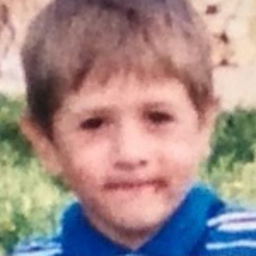

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Загружаем изображение с одним лицом</font></b>

!rm -rf /content/DFDNet/Results
!rm -rf /content/DFDNet/TestData/TestWhole/*
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one audio at a time!')

cont = uploaded[0]
CONTENT_FILENAME = "content." + cont.split(".")[-1]
os.rename(cont, CONTENT_FILENAME)
content_path = "/content/DFDNet/TestData/TestWhole/" + CONTENT_FILENAME
!mv -f $CONTENT_FILENAME $content_path

pil_content = Image.open(content_path)
(cont_width, cont_height) = pil_content.size
resize_cont = max(cont_width, cont_height)/256

clear_output()
display(pil_content.resize((int(cont_width/resize_cont), int(cont_height/resize_cont))))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Запускаем улучшение</font></b>

upscale_factor = 4 #@param {type:"slider", min:1, max:4, step:1}
os.chdir('/content/DFDNet/')
!python test_FaceDict.py --test_path ./TestData/TestWhole --results_dir ./Results/TestWholeResults --upscale_factor $upscale_factor --gpu_ids 0
clear_output()
enchance_face_path = '/content/DFDNet/Results/TestWholeResults/Step3_RestoreCropFace/' + CONTENT_FILENAME
try: 
  pil_result = Image.open(enchance_face_path)
  (res_width, res_height) = pil_result.size
  resize_res = max(res_width, res_height)/256
  display(pil_result.resize((int(res_width/resize_res), int(res_height/resize_res))))
except: pass

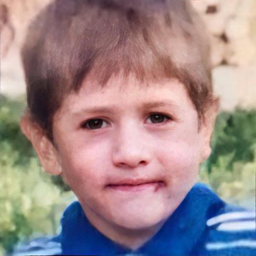

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Объединяем с оригинальным изображением</font></b>

print('\n###############################################################################')
print('############### Step 4: Paste the Restored Face to the Input Image ############')
print('###############################################################################\n')
from data.image_folder import make_dataset
from skimage import io
import numpy as np
import cv2
import dlib

def reverse_align(input_path, face_path, param_path, save_path, upsample_scale=2):
    out_size = (512, 512) 
    input_img = dlib.load_rgb_image(input_path)
    h,w,_ = input_img.shape
    face512 = dlib.load_rgb_image(face_path)
    inv_M = np.loadtxt(param_path)
    inv_crop_img = cv2.warpAffine(face512, inv_M, (w*upsample_scale,h*upsample_scale))
    mask = np.ones((512, 512, 3), dtype=np.float32) #* 255
    inv_mask = cv2.warpAffine(mask, inv_M, (w*upsample_scale,h*upsample_scale))
    upsample_img = cv2.resize(input_img, (w*upsample_scale, h*upsample_scale))
    inv_mask_erosion_removeborder = cv2.erode(inv_mask, np.ones((2 * upsample_scale, 2 * upsample_scale), np.uint8))# to remove the black border
    inv_crop_img_removeborder = inv_mask_erosion_removeborder * inv_crop_img
    total_face_area = np.sum(inv_mask_erosion_removeborder)//3
    w_edge = int(total_face_area ** 0.5) // 20 #compute the fusion edge based on the area of face
    erosion_radius = w_edge * 2
    inv_mask_center = cv2.erode(inv_mask_erosion_removeborder, np.ones((erosion_radius, erosion_radius), np.uint8))
    blur_size = w_edge * 2
    inv_soft_mask = cv2.GaussianBlur(inv_mask_center,(blur_size + 1, blur_size + 1),0)
    merge_img = inv_soft_mask * inv_crop_img_removeborder + (1 - inv_soft_mask) * upsample_img
    io.imsave(save_path, merge_img.astype(np.uint8))

TestImgPath = './TestData/TestWhole'
ResultsDir = './Results/TestWholeResults'
UpScaleWhole = upscale_factor
SaveRestorePath = os.path.join(ResultsDir,'Step3_RestoreCropFace')# Only Face Results
SaveFianlPath = os.path.join(ResultsDir,'Step4_FinalResults')
SaveParamPath = os.path.join(ResultsDir,'Step1_AffineParam') #save the inverse affine parameters
if not os.path.exists(SaveFianlPath):
    os.makedirs(SaveFianlPath)
ImgPaths = make_dataset(SaveRestorePath)
for i,ImgPath in enumerate(ImgPaths):
    ImgName = os.path.split(ImgPath)[-1]
    print('Final Restoring {}'.format(ImgName))
    WholeInputPath = os.path.join(TestImgPath,ImgName)
    FaceResultPath = os.path.join(SaveRestorePath, ImgName)
    ParamPath = os.path.join(SaveParamPath, ImgName+'.npy')
    SaveWholePath = os.path.join(SaveFianlPath, ImgName)
    reverse_align(WholeInputPath, FaceResultPath, ParamPath, SaveWholePath, UpScaleWhole)

clear_output()
enchance_img_path = '/content/DFDNet/Results/TestWholeResults/Step4_FinalResults/' + CONTENT_FILENAME
try: 
  pil_result = Image.open(enchance_img_path)
  (res_width, res_height) = pil_result.size
  resize_res = max(res_width, res_height)/256
  display(pil_result.resize((int(res_width/resize_res), int(res_height/resize_res))))
except: pass

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Скачиваем итоговый результат</font></b>
try: files.download(enchance_img_path)
except: files.download(enchance_face_path)